In [ ]:
#!/usr/bin/python
#encoding:utf-8
 
"""
@author: LlQ
@contact:LIQINGLIN54951@gmail.com
@file：ipProxy.py
@time: 9/7/2019 3:04 AM
"""
 
#https://www.cnblogs.com/Micro0623/p/10905193.html
#https://www.cnblogs.com/jackadam/p/9293569.html
#http://www.mamicode.com/info-detail-2694399.html
#https://www.cppentry.com/bencandy.php?fid=77&id=213146
#https://sites.google.com/a/chromium.org/chromedriver/capabilities
#https://blog.csdn.net/zwq912318834/article/details/78933910
#https://github.com/stormdony/python_demo/tree/master/TaoBao_Login
 
#Under the Anaconda Prompt
#pip install fake-useragent
from fake_useragent import UserAgent
from selenium import webdriver
from lxml import etree
import pandas as pd
 
domainList=["https://www.xicidaili.com"]
domain = domainList[0]
url = '/nn/3818'
###########responding to anti-crawler
#####UserAgent
userAgent = UserAgent()#User agent, or ua, is a special string header that enables the server
                        # to identify the operating system and version, cpu type,
                        # browser and version, browser rendering engine, browser language,
                        # browser plug-in, etc. used by the client.
 
#print(userAgent.ie) #Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64;
                        # Trident/4.0; SLCC2; Media Center PC 6.0; InfoPath.2; MS-RTC LM 8
#print(userAgent.firefox)
            #Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:25.0) Gecko/20100101 Firefox/25.0
#print(userAgent.chrome) #Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36
                            # (KHTML, like Gecko) Chrome/27.0.1453.93 Safari/537.36
#print(userAgent.random) #Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko)
                            # Chrome/27.0.1453.90 Safari/537.36
 
 
###########responding to anti-crawler
#actual User-Agent
# (right click your mouse then select Inspection
# and then you can find it from Headers by clicking any elementName Under Name in Network )
header={'UserAgent': "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/75.0.3770.100 Safari/537.36"}
#print(header['UserAgent']) #check
 
 
#from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument("'user-agent=" + header['UserAgent'] + "'")
options.add_argument('--diable-gpu') # 谷歌文档提到需要加上这个属性来规避bug
#options.add_argument('disable-infobars')# 去掉提示：Chrome正收到自动测试软件的控制
 
#browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver')
                           #chrome_options=options)
#if I run command("window.navigator.webdriver")in the Console of the inspection
#result: true  # means: Selenium + webdriver
#solution:
options.add_experimental_option('excludeSwitches', ['enable-automation'])
#此步骤很重要，设置为开发者模式，防止被各大网站识别出来使用了Selenium
 
 
#browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver',
#                           chrome_options=options)
#run command("window.navigator.webdriver")in the Console of the inspection
#result: undefine  # means: regular browser
 
#browser.get(url)
#print(browser.page_source)
 
class GetIp():
    def __init__(self,domain,baseUrl):
        self.domain=domain
        self.url=self.domain+str(baseUrl)
 
        self.browser = webdriver.Chrome(executable_path='D:/chromedriver/chromedriver',
                                        chrome_options=options
                                       )
 
    def __del__(self):
        self.browser.close()
 
    def get_webpagecontent(self):
        print(self.url)
        self.browser.get(self.url)
        pageSource = self.browser.page_source
        return pageSource
 
    def parse_webData(self, pageSource):
        #import pandas as pd                  #0: first row in dataframe
        df1 = pd.read_html(pageSource, header=0)[0]
        #Converting the chinese columnName to english name
        df1.columns = ['Country', 'IP Address', 'Port', 'Server Address', 'Anonymous',
                       'Type', 'Speed', 'Response Time', 'Available', 'Update']
        #from lxml import etree
        selector = etree.HTML(pageSource)
 
        countryDict = {'cn': 'China'}
        anonymousDict = {'高匿': 'Highly'}
 
        for r in range(df1.shape[0]):
            # for c in range(df1.shape[1]):
            if pd.isnull(df1.loc[r, 'Country']):
                # xpath will cost time, so we need to run several time
                try:
                    cn = \
                    selector.xpath('//table[@id="ip_list"]/tbody/tr[{0}]/td[@class="country"]/img/@alt'.format(r + 2))[
                        0]
                # print(cn) #Cn
                except:
                    print("run again")
                df1.loc[r, 'Country'] = countryDict[cn.lower()]
 
            if df1.loc[r, 'Anonymous'] in anonymousDict.keys():
                df1.loc[r, 'Anonymous'] = anonymousDict[df1.loc[r, 'Anonymous']]
            try:
                speed = \
                selector.xpath('//table[@id="ip_list"]/tbody/tr[{0}]/td[@class="country"]/div/@title'.format(r + 2))[0]
                df1.loc[r, "Speed"] = speed
            except:
                print("speed")
 
            try:
                res = \
                selector.xpath('//table[@id="ip_list"]/tbody/tr[{0}]/td[@class="country"]/div/@title'.format(r + 2))[1]
                df1.loc[r, "Response Time"] = res
            except:
                print("response")
        #df1.head()
        return df1
 
    def execute(self):
        pageSource = self.get_webpagecontent()
        ipDataFrame = self.parse_webData(pageSource)
        #print(ipDataFrame.head())
 
        hasNextPage = True
        #counter=0
        while hasNextPage:
            hasNextPage=False
            selector = etree.HTML(pageSource)
            try:
                nextPageUrl = selector.xpath('//div[@id="body"]/div[@class="pagination"]/a[@class="next_page"]/@href')[0]
                if nextPageUrl:
                    hasNextPage = True
            except:
                break
 
            self.url=self.domain+nextPageUrl
            pageSource = self.get_webpagecontent()
            currentIpDataFrame = self.parse_webData(pageSource)
            #print(currentIpDataFrame.head())
            ipDataFrame=pd.concat([ipDataFrame,currentIpDataFrame], ignore_index=True)
            #counter=counter+1
        return ipDataFrame
 
 
if __name__=="__main__":
 
    #print(domain + url)
    ipCrawler = GetIp(domain,url)
    ipDF=ipCrawler.execute()
    print(ipDF)

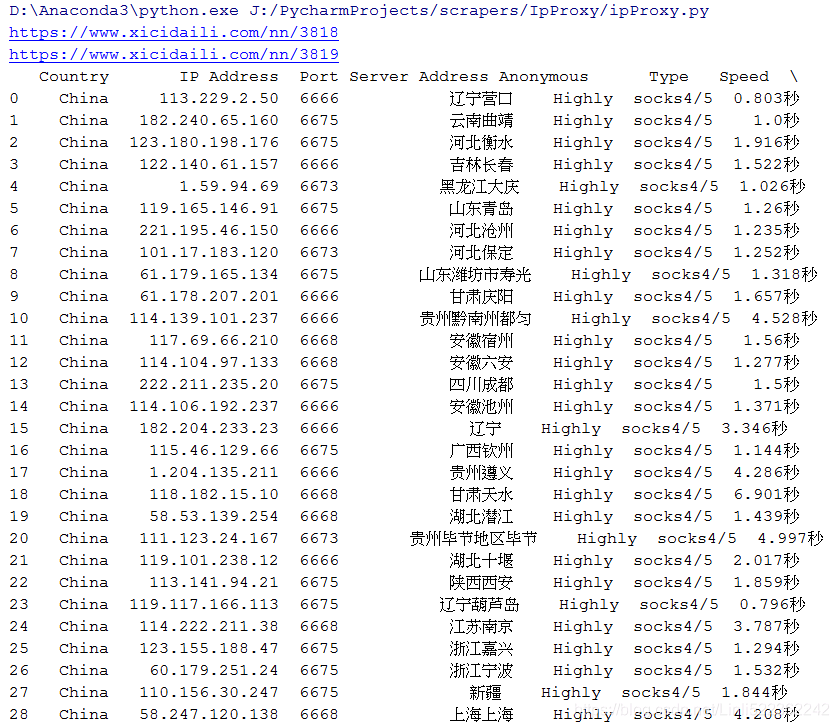